In [125]:
import gooseberry as gs
from dynamics import QQT
from tools import BlindColours, zero_balanced_weights

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [126]:
class QQT_new:
    def __init__(self, init_w1, init_w2, X, Y, weights_only=False):
        
        self.weights_only = weights_only
        self.batch_size = X.shape[0]

        self.input_dim = X.shape[1]
        self.output_dim = Y.shape[1]
        
        sigma_yx_tilde = 1 / self.batch_size * Y.T @ X 

        U_, S_, Vt_= np.linalg.svd(sigma_yx_tilde)
        V_ = Vt_.T 

        self.dim_diff = np.abs(self.input_dim - self.output_dim)

        if self.input_dim < self.output_dim:
            U_hat = U_[:, self.input_dim:]
            V_hat = np.zeros((self.input_dim, self.dim_diff))
            U_ = U_[:, :self.output_dim]

        elif self.input_dim > self.output_dim:
            U_hat = np.zeros((self.output_dim, self.dim_diff))
            V_hat = V_[:, self.output_dim:]
            V_ = V_[:, :self.output_dim]

        else:
            U_hat  = None 
            V_hat = None

        self.U_hat = U_hat 
        self.V_hat = V_hat 
        self.U_, self.S_, self.V_ = U_, np.diag(S_), V_

        U, S, Vt  = np.linalg.svd(init_w2 @ init_w1, full_matrices=False)
        self.U, self.S, self.V = U, S, Vt.T 

        self.B = self.U.T @ self.U_ + self.V.T @ self.V_ 
        self.C = self.U.T @ self.U_ - self.V.T @ self.V_



        ##CHECK THAT B IS NON SINGULAR
        self.t = 0

    def forward(self, learning_rate):
        #performs forward for one timestep

        time_step = self.t * learning_rate

        i = np.identity(self.input_dim) if self.input_dim < self.output_dim else np.identity(self.output_dim) 

        e_st_inv = np.diag(np.exp(-1. * np.diag(self.S_) * time_step))
        e_2st_inv = np.diag(np.exp(-2. * np.diag(self.S_) * time_step))

        B_inv = np.linalg.inv(self.B)

        Sinv = np.diag(1. / self.S)
        S_inv = np.diag(1. / np.diag(self.S_))

        # if self.t==10:
        #     print('QQT changed version:')
        #     print('V_: ', self.V_)
        #     print('U_: ', self.U_)
        #     print('e_st_inv: ', e_st_inv)
        #     print('C: ', self.C)
        #     print('B_inv: ', B_inv)
        #     print('V_hat: ', self.V_hat)
        #     print('V:  ', self.V)
        #     print('U_hat: ', self.U_hat)
        #     print('U:  ', self.U)

        if self.U_hat is None and self.V_hat is None:
            Z = np.vstack([
                self.V_ @ (i - e_st_inv @ self.C.T @ B_inv.T @ e_st_inv),
                self.U_ @ (i + e_st_inv @ self.C.T @ B_inv.T @ e_st_inv)
            ])
            center_right = 0.

        else:
            Z = np.vstack([
                self.V_ @ (i - e_st_inv @ self.C.T @ B_inv.T @ e_st_inv) + 2*self.V_hat@self.V_hat.T @ self.V @ B_inv.T @ e_st_inv,
                self.U_ @ (i + e_st_inv @ self.C.T @ B_inv.T @ e_st_inv) + 2*self.U_hat@self.U_hat.T @ self.U @ B_inv.T @ e_st_inv
            ])
            center_right = 4 * time_step * e_st_inv @ B_inv @ (self.V.T @ self.V_hat @ self.V_hat.T @ self.V + self.U.T @ self.U_hat @ self.U_hat.T @ self.U) @ B_inv.T @ e_st_inv

        center_left = 4. * e_st_inv @ B_inv @ Sinv @ B_inv.T @ e_st_inv 
        center_center = (i - e_2st_inv) @ S_inv- e_st_inv @ B_inv @ self.C @ (e_2st_inv - i) @ S_inv @ self.C.T @ B_inv.T @ e_st_inv
        
        # if self.t==1:
        #     print('New Version center_center variables: ')
        #     print('i: ', i)
        #     print('e_2st_inv: ', e_2st_inv)
        #     print('S_inv: ', S_inv)
        #     print('e_st_inv: ', e_st_inv)
        #     print('B_inv: ', B_inv)
        #     print('C: ', self.C)

        center = np.linalg.inv(center_left + center_center + center_right)

        qqt = Z @ center @ Z.T 
        if self.weights_only:
            qqt = qqt[self.input_dim:, :self.input_dim] 

        self.t+=1
        return qqt 

In [127]:
import torch
import torch.nn as nn 
import torch.optim as optim

import matplotlib.pyplot as plt 
import numpy as np

from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
import seaborn as sns
from tools import BlindColours, zero_balanced_weights


In [135]:
class LinearNetwork:
    def __init__(self, in_dim, hidden_dim, out_dim, init_w1 = None, init_w2 = None):

        if init_w1 is not None and init_w2 is not None:
            self.W1 = init_w1 
            self.W2 = init_w2
        else:
            self.W1 = np.random.randn(hidden_dim, in_dim)
            self.W2 = np.random.randn(out_dim, hidden_dim)
          # Weight matrix for input to hidden layer

    def forward(self, x):
        # Input to hidden layer

        
        self.z = self.W2 @ self.W1 @ x
        return self.z

    def backward(self, x, y, learning_rate):

        self.forward(x)


        # print('x shape: ', x.shape)
        # print('z shape: ', self.z.shape)
        # print('y shape: ', y.shape)
        # print('w1 shape: ', self.W1.shape)
        # print('w2 shape: ', self.W2.shape)
        dW1 = 1/x.shape[0] *self.W2.T @ (self.z-y) @ x.T 
        dW2 = 1/x.shape[0] * (self.z - y) @ x.T @ self.W1.T

        
        # Update parameters using gradients and learning rate
        self.W2 -= learning_rate * dW2
        self.W1 -= learning_rate * dW1


    def train(self, X_train, Y_train, epochs, learning_rate):
        w1s = []
        w2s = []
        print('X_train shape: ', X_train.shape)
        print('Y_train shape: ', Y_train.shape)
        losses = []
        print('epochs: ', epochs)
        for _ in range(epochs):
            loss = np.mean((self.forward(X_train) - Y_train) ** 2)
            losses.append(loss)
            w1s.append(self.W1)
            w2s.append(self.W2)
            self.backward(X_train, Y_train, learning_rate)
            # print(f"Epoch {epoch+1}/{epochs}, Loss: {loss}")

        return w1s, w2s, losses
    # def advance(state, y_hat, y):
    #     loss = 0.5 * np.mean(np.sum((y_hat - y)**2, axis=1))
    #     return state, loss


in_dim = 10
hidden_dim = 5
out_dim = 3
epochs = 1000
learning_rate = 0.01

# Create an instance of LinearNetwork
net = LinearNetwork(in_dim, hidden_dim, out_dim)

# Generate some synthetic training data
X_train = np.random.randn(in_dim, 100)
Y_train = np.random.randn(out_dim, 100)

# Train the network
losses = net.train(X_train, Y_train, epochs, learning_rate)

X_train shape:  (10, 100)
Y_train shape:  (3, 100)
epochs:  1000


In [129]:
#THE NETWORK'S WEIGHTS ARE OPTIMISED WITH FULL BATCH GRADIENT DESCEINT WITH LEARNING RATE TAU

# class LinearNetwork(nn.Module):
#     def __init__(self, in_dim, hidden_dim, out_dim, init_w1=None, init_w2=None):
#         super(LinearNetwork, self).__init__()
#         self.first_layer = nn.Linear(in_dim, hidden_dim)
#         self.second_layer = nn.Linear(hidden_dim , out_dim)

#         if init_w1 is not None:
#             self.first_layer.weight.data = init_w1.float()
#         if init_w2 is not None:
#             self.second_layer.weight.data = init_w2.float()

#     def forward(self, x):
#         x = self.first_layer(x)
#         x = self.second_layer(x)
#         return x 
    

# def train(model, X_train, y_train, criterion, optimizer, epochs):
    
#     w_ones = [model.first_layer.weight.data.clone().detach()]
#     w_twos = [model.second_layer.weight.data.clone().detach()]
#     losses = []

#     for epoch in range(epochs):
#         outputs = model(X_train)
#         loss = criterion(outputs, y_train)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         w_ones.append(model.first_layer.weight.data.clone().numpy())
#         w_twos.append(model.second_layer.weight.data.clone().numpy())
#         losses.append(loss.item())

#         if (epoch + 1) % 10 == 0:
#             print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    
#     w_ones = np.array(w_ones)
#     w_twos = np.array(w_twos)
#     losses = np.array(losses)

#     return w_ones, w_twos, losses


def whiten(X):

    scaler = StandardScaler()
    X_standardised = scaler.fit_transform(X)
    
    pca = PCA()
    X_pca = pca.fit_transform(X_standardised)

    X_whitened = torch.tensor(X_pca / np.sqrt(pca.explained_variance_), dtype=torch.float32)

    return X_whitened

def get_random_regression_task(batch_size, in_dim, out_dim):
    X = torch.randn(batch_size, in_dim)
    Y = torch.randn(batch_size, out_dim)
    X_whitened = whiten(X)

    return X_whitened, Y

X_train shape:  (10, 5)
Y_train shape:  (10, 2)
epochs:  0.1


TypeError: 'float' object cannot be interpreted as an integer

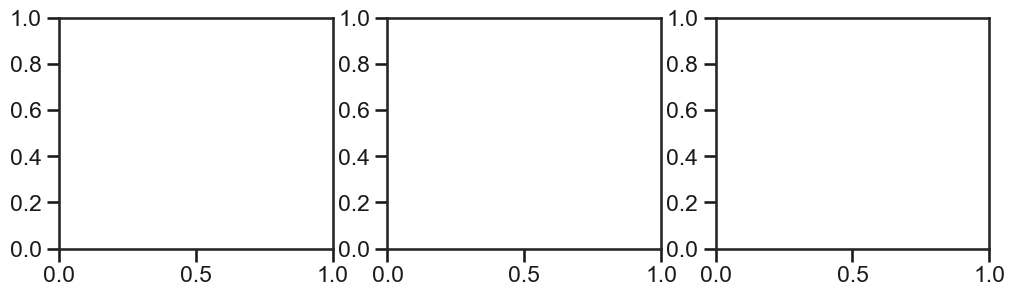

In [136]:
np.random.seed(1)

in_dim = 5
hidden_dim = 10
out_dim = 2

batch_size = 10
learning_rate = 0.1
training_steps = 400

plot_items_n = 4
blind_colours = BlindColours().get_colours()

init_w1, init_w2 = zero_balanced_weights(in_dim, hidden_dim, out_dim, .35)
train, _, _ = gs.datasets.StudentTeacher(batch_size, [init_w1, init_w2], [gs.datasets.Whiten()])

fig, axs = plt.subplots(1, 3, figsize=(12, 3.))

for i, initial_scale in enumerate([0.01, .25, .25]):
    task = gs.tasks.FullBatchLearning(train)
    optimiser = gs.GradientDescent(learning_rate)
    loss = gs.MeanSquaredError()

    init_w1, init_w2 = zero_balanced_weights(in_dim, hidden_dim, out_dim, initial_scale)
    
    mlp = gs.Network([
        gs.Linear(hidden_dim, bias=False, weight_init=gs.init.FromFixedValue(init_w1)),
        gs.Linear(out_dim, bias=False, weight_init=gs.init.FromFixedValue(init_w2))
    ])

    trainer = gs.Trainer(task, mlp, loss, optimiser)
    state, params = gs.assemble(1)

    losses = []
    ws = [params["network"]["layer-1"]["w"] @ params["network"]["layer-0"]["w"]]
    
    for training_step in range(training_steps):
        state, params, loss = trainer(state, params)
        losses.append(loss)
        ws.append(params["network"]["layer-1"]["w"] @ params["network"]["layer-0"]["w"])

    
    X, Y = train(None)

    init_w1, init_w2 = torch.tensor(init_w1), torch.tensor(init_w2)
    model = LinearNetwork(in_dim=in_dim, hidden_dim=hidden_dim, out_dim=out_dim, init_w1=init_w1, init_w2=init_w2)
    w1s, w2s, losses = model.train(X, Y, learning_rate, training_steps)
    # criterion = nn.MSELoss()
    # optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    # w1s, w2s, losses = train(model, torch.tensor(X), torch.tensor(Y), criterion, optimizer, training_steps)

    analytical = np.asarray([w2 @ w1 for (w2, w1) in zip(w2s, w1s)])


    # analytical = QQT_new(init_w1, init_w2, X, Y, True)
    # analytical = np.asarray([analytical.forward(learning_rate) for _ in range(training_steps)])
    

    outputs = (np.asarray(ws)[:, 0, :, :] @ X[:plot_items_n].T)
    for color, output in zip(blind_colours, outputs.T):
        for val in output:
            axs[i].plot(val, c=color, lw=2.5)
    axs[i].plot((analytical @ X[:plot_items_n].T).reshape(training_steps, -1), lw=3., c="k", alpha=0.7, linestyle=(0, (1, 2))) # (0, (3, 4, 3, 1))
    
    for color, target in zip(blind_colours, Y[:plot_items_n]):
        for value in target:
            axs[i].scatter(training_steps * 1.6, value, marker="_", color=color, lw=2.5)
    
    axs[i].set_xlim(1, training_steps * 1.6)
    axs[i].set_ylim([-2.2, 2.2])
    
    axs[i].set_xscale("log")
    
    axs[i].set_xlabel("Training Steps")
    if i == 0:
        sns.despine(ax=axs[i])
        axs[i].set_ylabel("Network Output")
        axs[i].set_yticks([-2, -1., 0., 1., 2])
    else:
        sns.despine(ax=axs[i], left=True)
        axs[i].set_yticks([])

first_task = outputs[1]
rng = np.linspace(0.57, 1., 10)
for color, output in zip(blind_colours, first_task.T):
    for val in output:
        axs[2].plot(rng, [val]*10, c=color, lw=2.5, clip_on=False, zorder=1)
        axs[2].plot(rng, [val]*10, lw=3., c="k", alpha=0.7, linestyle=(0, (1, 2)), clip_on=False, zorder=2)
axs[2].axvline(1., linestyle="--", c="grey", lw=2.5, clip_on=False, zorder=3)

for n, (color) in enumerate(blind_colours[:plot_items_n]):
    axs[2].plot(-5, -5, c=color, lw=2.5, label=f"Item {n + 1}")
axs[2].plot(-5, -5, lw=3., c="k", alpha=0.7, linestyle=(0, (1, 2)), label="Analytical")

fig.legend(loc=7, fontsize=14, frameon=False)
fig.tight_layout()
fig.subplots_adjust(right=0.85)

fig.savefig("./figures/figure-1_b-c-d.svg")



without tensor: 
init_w1:  tensor([[-0.0036,  0.0195,  0.0055, -0.0120,  0.0111],
        [-0.0102, -0.0026, -0.0040, -0.0017, -0.0212],
        [ 0.0059,  0.0025,  0.0036, -0.0007,  0.0027],
        [ 0.0043,  0.0054, -0.0021,  0.0156, -0.0099],
        [ 0.0076,  0.0101, -0.0160,  0.0002, -0.0098]], dtype=torch.float64)
init_w2:  tensor([[ 0.0174,  0.0032,  0.0010, -0.0068, -0.0091],
        [-0.0111,  0.0107, -0.0022, -0.0090, -0.0038],
        [ 0.0009,  0.0172, -0.0046,  0.0055,  0.0170],
        [-0.0147,  0.0114, -0.0048,  0.0080, -0.0083],
        [ 0.0069, -0.0052, -0.0034, -0.0131, -0.0074]], dtype=torch.float64)
with tensor: 
init_w1:  tensor([[-0.0036,  0.0195,  0.0055, -0.0120,  0.0111],
        [-0.0102, -0.0026, -0.0040, -0.0017, -0.0212],
        [ 0.0059,  0.0025,  0.0036, -0.0007,  0.0027],
        [ 0.0043,  0.0054, -0.0021,  0.0156, -0.0099],
        [ 0.0076,  0.0101, -0.0160,  0.0002, -0.0098]], dtype=torch.float64)
init_w2:  tensor([[ 0.0174,  0.0032,  0.0010, -0

/var/folders/x9/316v313n6_g8y8_p7fz_v6cw0000gn/T/ipykernel_42578/433804205.py:246: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  init_w1, init_w2 = torch.tensor(init_w1), torch.tensor(init_w2)


TypeError: unsupported operand type(s) for @: 'Tensor' and 'ArrayImpl'

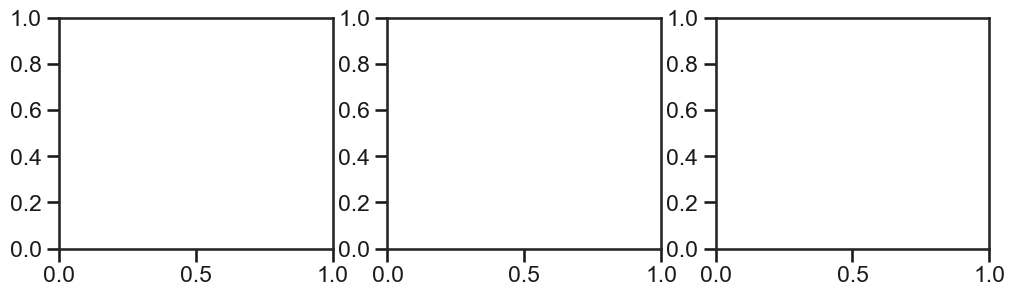

In [131]:
import gooseberry as gs
from dynamics import QQT
from tools import BlindColours, zero_balanced_weights

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import torch
import torch.nn as nn 
import torch.optim as optim

import matplotlib.pyplot as plt 
import numpy as np

from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
import seaborn as sns
from tools import BlindColours, zero_balanced_weights


class QQT_new:
    def __init__(self, init_w1, init_w2, X, Y, weights_only=False):
        
        self.weights_only = weights_only
        self.batch_size = X.shape[0]

        self.input_dim = X.shape[1]
        self.output_dim = Y.shape[1]
        
        sigma_yx_tilde = 1 / self.batch_size * Y.T @ X 

        U_, S_, Vt_= np.linalg.svd(sigma_yx_tilde)
        V_ = Vt_.T 

        self.dim_diff = np.abs(self.input_dim - self.output_dim)

        if self.input_dim < self.output_dim:
            U_hat = U_[:, self.input_dim:]
            V_hat = np.zeros((self.input_dim, self.dim_diff))
            U_ = U_[:, :self.output_dim]

        elif self.input_dim > self.output_dim:
            U_hat = np.zeros((self.output_dim, self.dim_diff))
            V_hat = V_[:, self.output_dim:]
            V_ = V_[:, :self.output_dim]

        else:
            U_hat  = None 
            V_hat = None

        self.U_hat = U_hat 
        self.V_hat = V_hat 
        self.U_, self.S_, self.V_ = U_, np.diag(S_), V_

        U, S, Vt  = np.linalg.svd(init_w2 @ init_w1, full_matrices=False)
        self.U, self.S, self.V = U, S, Vt.T 

        self.B = self.U.T @ self.U_ + self.V.T @ self.V_ 
        self.C = self.U.T @ self.U_ - self.V.T @ self.V_



        ##CHECK THAT B IS NON SINGULAR
        self.t = 0

    def forward(self, learning_rate):
        #performs forward for one timestep

        time_step = self.t * learning_rate

        i = np.identity(self.input_dim) if self.input_dim < self.output_dim else np.identity(self.output_dim) 

        e_st_inv = np.diag(np.exp(-1. * np.diag(self.S_) * time_step))
        e_2st_inv = np.diag(np.exp(-2. * np.diag(self.S_) * time_step))

        B_inv = np.linalg.inv(self.B)

        Sinv = np.diag(1. / self.S)
        S_inv = np.diag(1. / np.diag(self.S_))

        # if self.t==10:
        #     print('QQT changed version:')
        #     print('V_: ', self.V_)
        #     print('U_: ', self.U_)
        #     print('e_st_inv: ', e_st_inv)
        #     print('C: ', self.C)
        #     print('B_inv: ', B_inv)
        #     print('V_hat: ', self.V_hat)
        #     print('V:  ', self.V)
        #     print('U_hat: ', self.U_hat)
        #     print('U:  ', self.U)

        if self.U_hat is None and self.V_hat is None:
            Z = np.vstack([
                self.V_ @ (i - e_st_inv @ self.C.T @ B_inv.T @ e_st_inv),
                self.U_ @ (i + e_st_inv @ self.C.T @ B_inv.T @ e_st_inv)
            ])
            center_right = 0.

        else:
            Z = np.vstack([
                self.V_ @ (i - e_st_inv @ self.C.T @ B_inv.T @ e_st_inv) + 2*self.V_hat@self.V_hat.T @ self.V @ B_inv.T @ e_st_inv,
                self.U_ @ (i + e_st_inv @ self.C.T @ B_inv.T @ e_st_inv) + 2*self.U_hat@self.U_hat.T @ self.U @ B_inv.T @ e_st_inv
            ])
            center_right = 4 * time_step * e_st_inv @ B_inv @ (self.V.T @ self.V_hat @ self.V_hat.T @ self.V + self.U.T @ self.U_hat @ self.U_hat.T @ self.U) @ B_inv.T @ e_st_inv

        center_left = 4. * e_st_inv @ B_inv @ Sinv @ B_inv.T @ e_st_inv 
        center_center = (i - e_2st_inv) @ S_inv- e_st_inv @ B_inv @ self.C @ (e_2st_inv - i) @ S_inv @ self.C.T @ B_inv.T @ e_st_inv
        
        # if self.t==1:
        #     print('New Version center_center variables: ')
        #     print('i: ', i)
        #     print('e_2st_inv: ', e_2st_inv)
        #     print('S_inv: ', S_inv)
        #     print('e_st_inv: ', e_st_inv)
        #     print('B_inv: ', B_inv)
        #     print('C: ', self.C)

        center = np.linalg.inv(center_left + center_center + center_right)

        qqt = Z @ center @ Z.T 
        if self.weights_only:
            qqt = qqt[self.input_dim:, :self.input_dim] 

        self.t+=1
        return qqt 
    

def whiten(X):

    scaler = StandardScaler()
    X_standardised = scaler.fit_transform(X)
    
    pca = PCA()
    X_pca = pca.fit_transform(X_standardised)

    X_whitened = torch.tensor(X_pca / np.sqrt(pca.explained_variance_), dtype=torch.float32)

    return X_whitened

def get_random_regression_task(batch_size, in_dim, out_dim):
    X = torch.randn(batch_size, in_dim)
    Y = torch.randn(batch_size, out_dim)
    X_whitened = whiten(X)

    return X_whitened, Y


in_dim = 5
hidden_dim =5
out_dim = 5

batch_size = 10
learning_rate = 0.01
training_steps = 400

plot_items_n = 4
blind_colours = BlindColours().get_colours()

init_w1, init_w2 = zero_balanced_weights(in_dim, hidden_dim, out_dim, .35)
train_data, _, _ = gs.datasets.StudentTeacher(batch_size, [init_w1, init_w2], [gs.datasets.Whiten()])

fig, axs = plt.subplots(1, 3, figsize=(12, 3.))

for i, initial_scale in enumerate([0.01, .25, .25]):
    task = gs.tasks.FullBatchLearning(train_data)
    optimiser = gs.GradientDescent(learning_rate)
    loss = gs.MeanSquaredError()

    init_w1, init_w2 = zero_balanced_weights(in_dim, hidden_dim, out_dim, initial_scale)
    init_w1, init_w2 = torch.tensor(init_w1), torch.tensor(init_w2)
    
    mlp = gs.Network([
        gs.Linear(hidden_dim, bias=False, weight_init=gs.init.FromFixedValue(init_w1)),
        gs.Linear(out_dim, bias=False, weight_init=gs.init.FromFixedValue(init_w2))
    ])

    trainer = gs.Trainer(task, mlp, loss, optimiser)
    state, params = gs.assemble(1)

    losses = []
    ws = [params["network"]["layer-1"]["w"] @ params["network"]["layer-0"]["w"]]
    
    for training_step in range(training_steps):
        state, params, loss = trainer(state, params)
        losses.append(loss)
        ws.append(params["network"]["layer-1"]["w"] @ params["network"]["layer-0"]["w"])

    
    X, Y = train_data(None)

    print('without tensor: ')
    print('init_w1: ', init_w1)
    print('init_w2: ', init_w2)
    init_w1, init_w2 = torch.tensor(init_w1), torch.tensor(init_w2)
    print('with tensor: ')
    print('init_w1: ', init_w1)
    print('init_w2: ', init_w2)

    model = LinearNetwork(in_dim=in_dim, hidden_dim=hidden_dim, out_dim=out_dim, init_w1=init_w1, init_w2=init_w2)
    # train(self, X_train, Y_train, epochs, learning_rate):
    w1s, w2s, losses = model.train(X, Y, epochs, learning_rate)
    # criterion = nn.MSELoss()
    # optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    # w1s, w2s, losses2 = train(model, torch.tensor(np.array(X)), torch.tensor(np.array(Y)), criterion, optimizer, training_steps)

    analytical = np.asarray([w2 @ w1 for (w2, w1) in zip(w2s, w1s)])


    # analytical = QQT_new(init_w1, init_w2, X, Y, True)
    # analytical = np.asarray([analytical.forward(learning_rate) for _ in range(training_steps)])
    

    outputs = (np.asarray(ws)[:, 0, :, :] @ X[:plot_items_n].T)
    for color, output in zip(blind_colours, outputs.T):
        for val in output:
            axs[i].plot(val, c=color, lw=2.5)
    axs[i].plot((analytical[:-1] @ X[:plot_items_n].T).reshape(training_steps, -1), lw=3., c="k", alpha=0.7, linestyle=(0, (1, 2))) # (0, (3, 4, 3, 1))
    
    for color, targetf in zip(blind_colours, Y[:plot_items_n]):
        for value in target:
            axs[i].scatter(training_steps * 1.6, value, marker="_", color=color, lw=2.5)
    
    axs[i].set_xlim(1, training_steps * 1.6)
    axs[i].set_ylim([-2.2, 2.2])
    
    axs[i].set_xscale("log")
    
    axs[i].set_xlabel("Training Steps")
    if i == 0:
        sns.despine(ax=axs[i])
        axs[i].set_ylabel("Network Output")
        axs[i].set_yticks([-2, -1., 0., 1., 2])
    else:
        sns.despine(ax=axs[i], left=True)
        axs[i].set_yticks([])

first_task = outputs[1]
rng = np.linspace(0.57, 1., 10)
for color, output in zip(blind_colours, first_task.T):
    for val in output:
        axs[2].plot(rng, [val]*10, c=color, lw=2.5, clip_on=False, zorder=1)
        axs[2].plot(rng, [val]*10, lw=3., c="k", alpha=0.7, linestyle=(0, (1, 2)), clip_on=False, zorder=2)
axs[2].axvline(1., linestyle="--", c="grey", lw=2.5, clip_on=False, zorder=3)

for n, (color) in enumerate(blind_colours[:plot_items_n]):
    axs[2].plot(-5, -5, c=color, lw=2.5, label=f"Item {n + 1}")
axs[2].plot(-5, -5, lw=3., c="k", alpha=0.7, linestyle=(0, (1, 2)), label="My Empirical")

fig.legend(loc=7, fontsize=14, frameon=False)
fig.tight_layout()
fig.subplots_adjust(right=0.85)

fig.savefig("./figures/figure-1_b-c-d.svg")



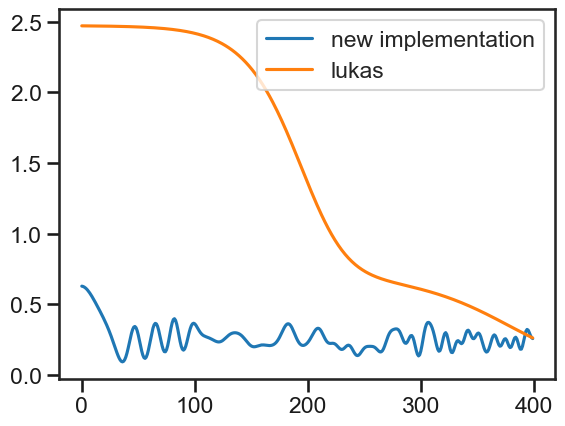

In [132]:
plt.figure()
plt.plot(losses2, label='new implementation')
plt.plot(losses, label='lukas')
plt.legend()

In [133]:
losses[-1]

Array([0.26333582], dtype=float32)

In [118]:
losses2[-1]

0.25858354568481445

In [119]:
zip(analyti)

NameError: name 'analyti' is not defined

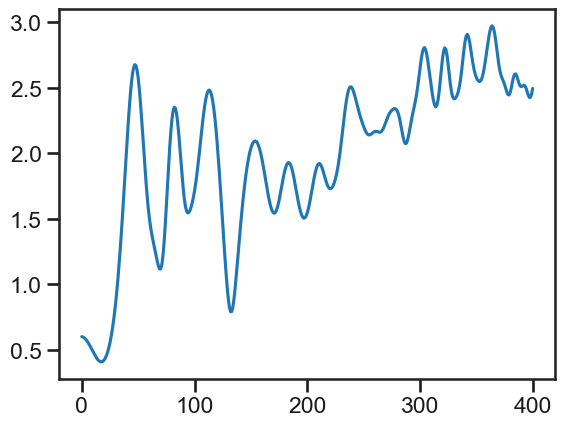

In [120]:
diffs = [np.linalg.norm(a - w) for (a, w) in zip(analytical, ws)]
plt.plot(diffs)

In [121]:
diffs

[0.59898543,
 0.59633964,
 0.59111565,
 0.58344096,
 0.5735034,
 0.5615479,
 0.54787195,
 0.5328208,
 0.51678234,
 0.5001822,
 0.4834792,
 0.46715993,
 0.451734,
 0.43772793,
 0.42567715,
 0.41611573,
 0.40956327,
 0.4065105,
 0.40740553,
 0.41264567,
 0.42257732,
 0.4375071,
 0.45772207,
 0.48351544,
 0.51521105,
 0.5531818,
 0.59785867,
 0.6497262,
 0.7093072,
 0.7771343,
 0.8537104,
 0.9394583,
 1.0346608,
 1.139391,
 1.2534375,
 1.376226,
 1.5067409,
 1.6434596,
 1.7843018,
 1.9266115,
 2.0671787,
 2.2023146,
 2.3279839,
 2.4399996,
 2.5342665,
 2.6070602,
 2.6553147,
 2.676886,
 2.670763,
 2.6371949,
 2.5777333,
 2.495171,
 2.3933997,
 2.2771993,
 2.1519732,
 2.0234363,
 1.8972497,
 1.778586,
 1.6716301,
 1.579065,
 1.5016707,
 1.4382166,
 1.3857787,
 1.3404692,
 1.2984117,
 1.2567466,
 1.214521,
 1.1733876,
 1.1380217,
 1.1159866,
 1.1165578,
 1.1481919,
 1.2154019,
 1.3169296,
 1.4463503,
 1.5941775,
 1.7498764,
 1.9031224,
 2.044459,
 2.165683,
 2.2601519,
 2.32307,
 2.351741,


In [122]:
losses2

array([0.62930602, 0.62743592, 0.62373531, 0.61828101, 0.61118323,
       0.60258001, 0.59263062, 0.58150721, 0.56938738, 0.5564459 ,
       0.54284769, 0.52874076, 0.5142507 , 0.4994764 , 0.48448712,
       0.46932018, 0.45398074, 0.43844247, 0.42264935, 0.40651965,
       0.38995031, 0.37282422, 0.35501853, 0.33641639, 0.31692085,
       0.29647154, 0.27506596, 0.25278184, 0.22980395, 0.20644978,
       0.18319534, 0.16069379, 0.13978414, 0.12148169, 0.10694302,
       0.09739787, 0.09404236, 0.09789259, 0.10960606, 0.1292882 ,
       0.1563144 , 0.18920775, 0.22561771, 0.26243767, 0.29608083,
       0.32289946, 0.3396965 , 0.3442395 , 0.33567801, 0.31476828,
       0.28385094, 0.24657658, 0.20743035, 0.17114231, 0.14208421,
       0.12374255, 0.1183283 , 0.12655506, 0.1475895 , 0.17916211,
       0.21781869, 0.25928941, 0.29894733, 0.33232072, 0.35561115,
       0.36616284, 0.36282003, 0.34612191, 0.3182956 , 0.28303891,
       0.24510854, 0.20975599, 0.18206984, 0.16629595, 0.16521

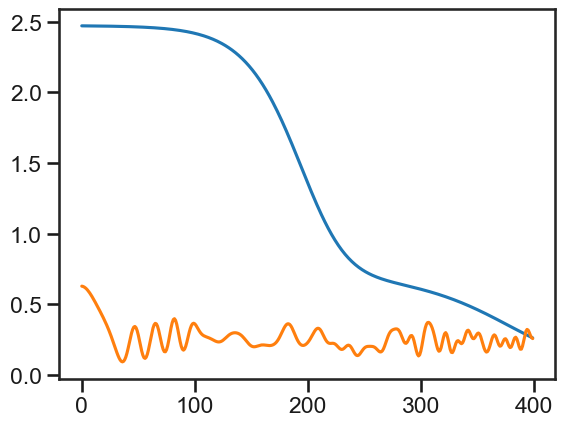

In [123]:
plt.figure()
plt.plot(losses)
plt.plot(losses2)

In [124]:
class LinearNetwork:
    def __init__(self, in_dim, hidden_dim, out_dim, init_w1 = None, init_w2 = None):

        if init_w1 is not None and init_w2 is not None:
            self.W1 = init_w1 
            self.W2 = init_w2
        else:
            self.W1 = np.random.randn(hidden_dim, in_dim)
            self.W2 = np.random.randn(out_dim, hidden_dim)
          # Weight matrix for input to hidden layer

    def forward(self, x):
        # Input to hidden layer

        
        self.z = self.W2 @ self.W1 @ x
        return self.z

    def backward(self, x, y, learning_rate):

        self.forward(x)


        # print('x shape: ', x.shape)
        # print('z shape: ', self.z.shape)
        # print('y shape: ', y.shape)
        # print('w1 shape: ', self.W1.shape)
        # print('w2 shape: ', self.W2.shape)
        dW1 = 1/x.shape[0] *self.W2.T @ (self.z-y) @ x.T 
        dW2 = 1/x.shape[0] * (self.z - y) @ x.T @ self.W1.T

        
        # Update parameters using gradients and learning rate
        self.W2 -= learning_rate * dW2
        self.W1 -= learning_rate * dW1


    def train(self, X_train, Y_train, epochs, learning_rate):
        w1s = []
        w2s = []
        print('X_train shape: ', X_train.shape)
        print('Y_train shape: ', Y_train.shape)
        losses = []
        for _ in range(epochs):
            loss = np.mean((self.forward(X_train) - Y_train) ** 2)
            losses.append(loss)
            w1s.append(self.W1)
            w2s.append(self.W2)
            self.backward(X_train, Y_train, learning_rate)
            # print(f"Epoch {epoch+1}/{epochs}, Loss: {loss}")

        return w1s, w2s, losses
    # def advance(state, y_hat, y):
    #     loss = 0.5 * np.mean(np.sum((y_hat - y)**2, axis=1))
    #     return state, loss


in_dim = 10
hidden_dim = 5
out_dim = 3
epochs = 1000
learning_rate = 0.01

# Create an instance of LinearNetwork
net = LinearNetwork(in_dim, hidden_dim, out_dim)

# Generate some synthetic training data
X_train = np.random.randn(in_dim, 100)
Y_train = np.random.randn(out_dim, 100)

# Train the network
losses = net.train(X_train, Y_train, epochs, learning_rate)

X_train shape:  (10, 100)
Y_train shape:  (3, 100)


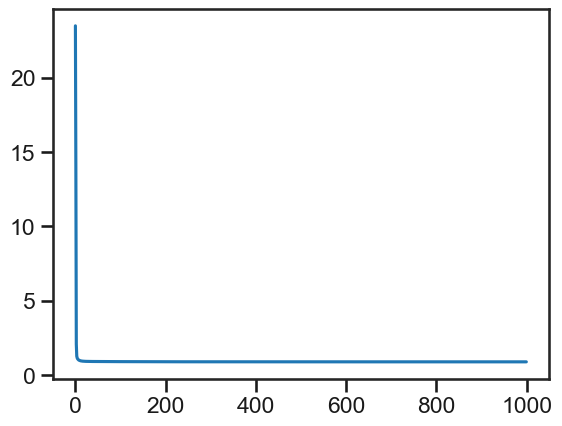

In [90]:
plt.plot(losses)